In [1]:
%pip install langchain langchain-google-genai langchain_community tavily-python aiosqlite langchain-tavily 
%pip install langgraph-checkpoint-sqlite 
%pip install langgraph langgraph-checkpoint-sqlite
%pip install langgraph 

  Using cached google_ai_generativelanguage-0.6.18-py3-none-any.whl.metadata (9.8 kB)
Using cached google_ai_generativelanguage-0.6.18-py3-none-any.whl (1.4 MB)
  Attempting uninstall: google-ai-generativelanguage
    Found existing installation: google-ai-generativelanguage 0.6.15
    Uninstalling google-ai-generativelanguage-0.6.15:
      Successfully uninstalled google-ai-generativelanguage-0.6.15
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.18 which is incompatible.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


In [2]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage

import sqlite3 
from langgraph.checkpoint.sqlite import SqliteSaver 
conn = sqlite3.connect("checkpoints.db", check_same_thread=False) 
memory = SqliteSaver(conn)

In [3]:
import google.generativeai as genai
import os
from dotenv import load_dotenv

load_dotenv()

os.environ['GOOGLE_API_KEY'] = os.getenv('GEMINI_API_KEY') 
os.environ['TAVILY_API_KEY'] = os.getenv('TAVILY_API_KEY')

In [ ]:
from typing import TypedDict, List

class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

In [5]:
from langchain_google_genai import ChatGoogleGenerativeAI

model = ChatGoogleGenerativeAI(model="gemini-1.5-flash", temperature=0)

In [6]:
PLAN_PROMPT = """Você é um escritor especialista com a tarefa de criar um esboço de alto nível para uma redação. \
Escreva esse esboço para o tópico fornecido pelo usuário. Apresente um plano da redação junto com quaisquer notas \
ou instruções relevantes para as seções."""

In [7]:
WRITER_PROMPT = """Você é um assistente de redação com a tarefa de escrever excelentes redações de 5 parágrafos. \
Gere a melhor redação possível para a solicitação do usuário e o esboço inicial. \
Se o usuário fornecer críticas, responda com uma versão revisada das suas tentativas anteriores. \
Utilize todas as informações abaixo conforme necessário:

------

{content}"""

In [ ]:
REFLECTION_PROMPT = """Você é um professor corrigindo uma redação submetida. \
Gere uma crítica e recomendações para a submissão do usuário. \
Forneça recomendações detalhadas, incluindo pedidos sobre extensão, profundidade, estilo, etc."""


In [9]:
RESEARCH_PLAN_PROMPT = """Você é um pesquisador encarregado de fornecer informações que podem \
ser usadas ao escrever a seguinte redação. Gere uma lista de consultas de pesquisa que \
recolham quaisquer informações relevantes. Gere no máximo 3 consultas."""


In [10]:
RESEARCH_CRITIQUE_PROMPT = """Você é um pesquisador encarregado de fornecer informações que podem \
ser usadas ao fazer quaisquer revisões solicitadas (conforme descrito abaixo). \
Gere uma lista de consultas de pesquisa que recolham quaisquer informações relevantes. Gere no máximo 3 consultas."""


In [11]:
from langchain_core.pydantic_v1 import BaseModel

class Queries(BaseModel):
    queries: List[str]

c:\Users\cadup\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3553: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [12]:
from tavily import TavilyClient
import os
tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

sagemaker.config INFO - Not applying SDK defaults from location: C:\ProgramData\sagemaker\sagemaker\config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: C:\Users\cadup\AppData\Local\sagemaker\sagemaker\config.yaml


In [20]:
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT), 
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}

In [13]:
def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [14]:
def generation_node(state: AgentState):
    content = "\n\n".join(state['content'] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
    messages = [
        SystemMessage(
            content=WRITER_PROMPT.format(content=content)
        ),
        user_message
        ]
    response = model.invoke(messages)
    return {
        "draft": response.content, 
        "revision_number": state.get("revision_number", 1) + 1
    }


In [15]:
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT), 
        HumanMessage(content=state['draft'])
    ]
    response = model.invoke(messages)
    return {"critique": response.content}

In [16]:
def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [17]:
def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

In [18]:
builder = StateGraph(AgentState)

In [21]:
builder.add_node("planner", plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("research_critique", research_critique_node)

In [27]:
builder.set_entry_point("planner")

In [28]:
builder.add_conditional_edges(
    "generate", 
    should_continue, 
    {END: END, "reflect": "reflect"}
)


In [29]:
builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")

builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

In [30]:
graph = builder.compile(checkpointer=memory)


--- Tentando Gerar PNG do Grafo via Mermaid (Requer Playwright!) ---


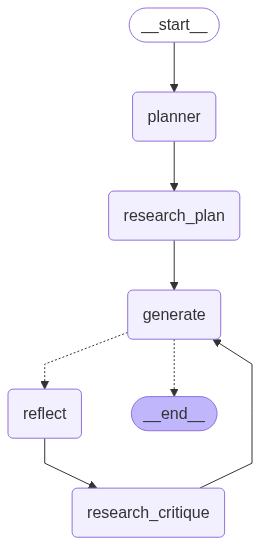

Grafo PNG gerado e exibido com sucesso!


In [31]:
from IPython.display import Image, display, Markdown
import os

print("\n--- Tentando Gerar PNG do Grafo via Mermaid (Requer Playwright!) ---")
try:

    image_data = graph.get_graph().draw_mermaid_png()
    display(Image(data=image_data))
    print("Grafo PNG gerado e exibido com sucesso!")

except Exception as e:

    print(f"\nErro ao tentar gerar o PNG do grafo: {e}")
    print("Isso pode ocorrer por:")
    print("1. O método `.draw_mermaid_png()` não existe na sua versão do LangGraph.")
    print("2. Faltam dependências como 'playwright' ou seus drivers não foram instalados.")
    print("   Tente: pip install playwright && playwright install")
    print("3. Outro erro inesperado ao acessar o grafo ou renderizar.")

    print("\n--- Tentando gerar apenas o código Mermaid (Fallback) ---")
    try:

        mermaid_code = graph.get_graph().draw_mermaid()
        print("\n--- Código Mermaid Gerado (Cole em https://mermaid.live/ ou use Markdown no notebook) ---")
        print(mermaid_code)

    except Exception as e_mermaid:
        print(f"Erro ao gerar código Mermaid: {e_mermaid}")
        print("Verifique se 'graph.get_graph()' está correto e acessível.")

In [32]:
thread = {"configurable": {"thread_id": "1"}}
for s in graph.stream({
    'task': "Qual é a diferença entre o langchain e langsmith",
    "max_revisions": 2,
    "revision_number": 1,
    "content": [], 
}, thread):
    print(s)

{'planner': {'plan': 'Aqui está um esboço de nível superior para uma redação que compara e contrasta o LangChain e o LangSmith:\n\n**I. Introdução**\n\n*   Comece definindo brevemente o LangChain e o LangSmith.\n*   Mencione que ambos são ferramentas importantes no ecossistema de IA de linguagem grande (LLM), mas servem a propósitos diferentes.\n*   Declare o objetivo da redação: comparar e contrastar suas funcionalidades, vantagens e desvantagens.\n\n**II. LangChain: Uma visão geral**\n\n*   Defina o LangChain como um framework para construir aplicativos com LLMs.\n*   Destaque suas principais funcionalidades:\n    *   Integração com vários LLMs (OpenAI, Hugging Face, etc.)\n    *   Cadeias de modelos para orquestrar diferentes LLMs e componentes.\n    *   Memória para manter o contexto em conversas.\n    *   Indexação e busca para acessar e processar dados externos.\n*   Discuta os casos de uso do LangChain:\n    *   Chatbots\n    *   Assistentes virtuais\n    *   Sistemas de recomen